# Case Study - France Covid-19
Using ABC-methods to fit models to covid-19 data from France between 24th Jan 2020 (First confirmed cases) and 31st March 2020.

In [1]:
from scipy import stats
import Models
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import ABC

# silence warnings about dodgy division
np.seterr(divide='ignore', invalid='ignore')

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

## Helper Methods

In [2]:
# print results
def print_results(results,num_stats=None):
    used=[]
    n=len(results)
    for x in results:
        if x not in used:
            used.append(x)
            print("([{}],{:.2f}%)".format(",".join([str(y) for y in x]),100*(results.count(x)/n)))
            
    if (num_stats):
        for i in range(num_stats):
            print("(ss_{},{:.2f}%)".format(i,100*(sum(i in row for row in results)/n)))

In [3]:
def estimate_r0(accepted_params,weights=None,interval_width=.9):
    if (interval_width<=0) or (interval_width>=1): raise ValueError("`interval_width` must be in (0,1)")
    
    weights=weights if (weights) else [1/len(accepted_params) for _ in range(len(accepted_params))]
    
    r0s=[]
    for _ in range(1000):
        ind=np.random.choice(len(accepted_params),size=1,p=weights)
        params=accepted_params[ind[0]]
        r0s.append(params[2]/params[3])
    
    lower_bound=(1-interval_width)/2
    upper_bound=1-lower_bound
    
    return np.quantile(r0s,lower_bound),np.quantile(r0s,upper_bound)

In [4]:
def ci_parameters(accepted_values,alpha=.05,weights=None):
    
    if (weights):
        zipped = zip(accepted_values, weights)
        weighted = []
        for (a, w) in zipped:
            w=int(1000*w)
            for j in range(w):
                weighted.append(a)
    else: weighted=accepted_values
    
    ub=np.percentile(weighted,100*(1-alpha/2),axis=0)
    lb=np.percentile(weighted,100*(alpha/2),axis=0)
    
    return (lb,ub)

In [5]:
def ir_plot(model):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    ax.margins(0)

    xs=model.x_obs
    ys=model.observe()

    # I
    i=1
    y_obs=[y[i] for y in ys]
    ax.scatter(xs,y_obs,c="blue",label="Infectious")

    # R
    i=2
    y_obs=[y[i] for y in ys]
    ax.scatter(xs,y_obs,c="red",label="Removed")

    y_min=0
    y_max=4*(max(max([y[1] for y in ys]),max([y[2] for y in ys])))
    y_max=1000*(1+min(y_max,ax.get_ylim()[1])//1000)
    
    ax.set_ylim(y_min,y_max)
    
    
    ax.set_xlabel("Days",fontsize=16)
    ax.set_ylabel("Population Size",fontsize=16)

    ax.set_xticks(list(range(0,max(xs,key=lambda x:x[0])[0],7))+xs[-1])
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 5))

    plt.legend()
    plt.grid()
    plt.show()

In [6]:
def plot_accepted_ir_observations(ax:plt.Axes,x_obs:int,y_obs:[[float]],accepted_params:[[float]],predicted_model:Models.Model) -> plt.Axes:
    
    accepted_observations=[predicted_model.copy(params).observe() for params in accepted_params]
    
    # plot acceped
    for obs in accepted_observations:
        i_obs=[y[1] for y in obs]
        r_obs=[y[2] for y in obs]
        
        ax.scatter(x_obs,i_obs,c="blue",alpha=.5,marker="x")
        ax.scatter(x_obs,r_obs,c="red",alpha=.5,marker="x")

    # plot observed
    ax.plot(x_obs,[y[1] for y in y_obs],c="blue") # label="Observed I"
    ax.plot(x_obs,[y[2] for y in y_obs],c="red") # label="Observed R"
    
    # plot predicition
    y_pred=predicted_model.observe()
    ax.plot(x_obs,[y[1] for y in y_pred],c="blue",ls="--") # label="Observed I"
    ax.plot(x_obs,[y[2] for y in y_pred],c="red",ls="--") # label="Observed R"

    # make legend
    f = lambda m,l,c: ax.plot([],[], marker=m,color=c,ls=l)[0]
    handles = [f("s","",c) for c in ["blue","red"]]
    handles+=[f("x","","black")]
    handles+= [f(None,l,"black") for l in ["-","--"]]

    ax.legend(handles=handles,labels=["I","R","Accepted","Observed","Predicted"],loc="upper left",ncol=2)
    
    y_min=0
    y_max=4000*(max(max([y[1] for y in y_obs]),max([y[2] for y in y_obs]))//100 +1)
    y_max=min(y_max,ax.get_ylim()[1])
    
    ax.set_ylim(y_min,y_max)
    
    ax.set_xlabel("Day",fontsize=16)
    ax.set_ylabel("Population Size",fontsize=16)

    ax.set_xticks(list(range(0,max(x_obs,key=lambda x:x[0])[0],5))+x_obs[-1])
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 5))
    
    ax.margins(0)

    return ax


In [7]:
def plot_parameter_posteriors(parameter_names:[str],accepted_parameters:[[float]],predicted_vals:[float],priors:["stats.Distribution"],weights=None) -> plt.Figure:
    fig=plt.Figure()

    weights = weights if (weights) else [1/len(accepted_parameters) for _ in range(len(accepted_parameters))]
    
    acc_params_x=[p[0] for p in accepted_parameters]
    acc_params_y=[p[1] for p in accepted_parameters]
    
    fig = plt.figure()
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    # plot scatter
    sns.kdeplot(acc_params_x,acc_params_y,cmap="Blues", shade=True,weights=weights,ax=ax_scatter)
    
    # plot accepted data
    ax_hist_x.hist(acc_params_x,density=True)
    ax_hist_y.hist(acc_params_y,orientation='horizontal',density=True)

    # plot priors used
    hist_x_xs=np.linspace(min(acc_params_x+[priors[0].ppf(.01)-.25]),max(acc_params_x+[priors[0].ppf(.99)+.25]),100)
    ax_hist_x.plot(hist_x_xs,priors[0].pdf(hist_x_xs),"k-",lw=2, label='Prior')
    hist_y_xs=np.linspace(min(acc_params_y+[priors[1].ppf(.01)-.25]),max(acc_params_y+[priors[1].ppf(.99)+.25]),100)
    ax_hist_y.plot(priors[1].pdf(hist_y_xs),hist_y_xs,"k-",lw=2, label='Prior')
    
    # plot smooth posterior (ie KDE)
    density_x=stats.kde.gaussian_kde(acc_params_x,weights=weights)
    ax_hist_x.plot(hist_x_xs,density_x(hist_x_xs),"--",lw=2,c="orange",label="Posterior KDE")
    density_y=stats.kde.gaussian_kde(acc_params_y,weights=weights)
    ax_hist_y.plot(density_y(hist_y_xs),hist_y_xs,"--",lw=2,c="orange",label="Posterior KDE")
        
    # plot posterior mean
    ax_hist_x.vlines(predicted_vals[0],ymin=0,ymax=ax_hist_x.get_ylim()[1],colors="orange")
    ax_hist_y.hlines(predicted_vals[1],xmin=0,xmax=ax_hist_y.get_xlim()[1],colors="orange")
    
    # make legend
    f = lambda m,l,c: ax_scatter.plot([],[], marker=m,color=c,ls=l)[0]
    handles=[f(None,"-","black"),f(None,"-","orange"),f(None,"--","orange"),f("s","","#1f77b4")]

#     ax_scatter.legend(handles=handles,labels=["Prior","Posterior Mean","Posterior KDE","Accepted"],fontsize=18)
    ax_scatter.set_xlim((hist_x_xs[0],hist_x_xs[-1]))
    ax_scatter.set_ylim((hist_y_xs[0],hist_y_xs[-1]))

    ax_scatter.set_xlabel(parameter_names[0])
    ax_scatter.set_ylabel(parameter_names[1])
    
    ax_scatter.margins(0)
    ax_hist_x.margins(0)
    ax_hist_y.margins(0)
    
    return fig


In [8]:
# plot of model projection with confidence intervals
def plot_ir_model_ci(ax,x_obs,y_obs,predicted_model,accepted_params,weights=None,alpha=0.05,legend=True):
    xs=x_obs
    ys=y_obs
    obs=[]
    
    weights=weights if(weights) else [1/len(accepted_params) for _ in range(len(accepted_params))]
    
    for _ in range(10000):
        ind=np.random.choice(len(accepted_params),size=1,p=weights)[0]
        params=accepted_params[ind]
        temp_model=predicted_model.copy(params)
        new_obs=temp_model.observe()
        obs.append(new_obs)
    
    # Plot true given data
    ax.plot(xs,[y[1] for y in ys],c="blue") # label="Observed I"
    ax.plot(xs,[y[2] for y in ys],c="red",) # label="Observed R"
    
    # Calculate & Plot Predictions
    means=[]
    upper_bounds=[]
    lower_bounds=[]
    
    for i in range(len(y_obs)):
        y_is=[o[i] for o in obs]
        
        mean=np.mean(y_is,axis=0)
        ub=np.percentile(y_is,100*(1-alpha/2),axis=0)
        lb=np.percentile(y_is,100*(alpha/2),axis=0)
        
        means+=[mean]
        upper_bounds+=[ub]
        lower_bounds+=[lb]
    
    # I
    i=1
#     ax.plot(xs,[m[i] for m in means],c="blue",ls="--") # label="Predicted I"
    ax.plot(xs,[y[i] for y in predicted_model.observe()],c="blue",ls="--") # label="Predicted I"
    ax.fill_between([x[0] for x in xs],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                   ,color="blue",alpha=.2)
    
    # R
    i=2
#     ax.plot(xs,[m[i] for m in means],c="red",ls="--") # label="Predicted R"
    ax.plot(xs,[y[i] for y in predicted_model.observe()],c="red",ls="--") # label="Predicted R"
    ax.fill_between([x[0] for x in xs],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                   ,color="red",alpha=.2)
    
    # make legend
    if (legend):
        f = lambda m,l,c: plt.plot([],[], marker=m,color=c,ls=l)[0]
        handles = [f("s","",c) for c in ["blue","red"]]
        handles+= [f(None,l,"black") for l in ["-","--"]]

        ax.legend(handles=handles,labels=["I","R","Observed","Fitted"],loc="upper left",ncol=2)
    
    y_min=0
    y_max=4*(max(max([y[1] for y in ys]),max([y[2] for y in ys])))
    y_max=1000*(1+min(y_max,ax.get_ylim()[1])//1000)
    
    ax.set_ylim(y_min,y_max)
    
    ax.set_title("{}% CI for Population Sizes.".format(int(100*(1-alpha))),fontsize=20)

    ax.set_xlabel("Day",fontsize=16)
    ax.set_ylabel("Population Size",fontsize=16)

    ax.set_xticks(list(range(0,max(xs,key=lambda x:x[0])[0],5))+xs[-1])
    ax.set_yticks(np.linspace(0, y_max, 5))

# Truncated Models
Models only include data in 30 days up to 17th March (start of national lockdown).

In [2]:
from Models import Model
class TrunFranceRonaData(Model):

    def __init__(self):
        """
        DESCRIPTION
        Covid-19 data for france between Jan 24 2020 & March 31 2020
        (Jan 24th = Date of first confirmed infections)
        """

        # all models have the following
        self.n_params=0 # number of parameters
        self.params=[] # parameter values

        self.n_obs=30 # number of observations made by `observe`
        self.dim_obs=3 # dimension of each observation

        self.x_obs=list([[i] for i in range(self.n_obs)])

        self.noise=0 # variance of additive gaussian noise (default=0)
        self.param_labels=None # names for each parameter (used for plotting so optional)

    def update_params(self,new_params:[float]):
        """
        DESCRIPTION
        update the parameters of the model. the observations for `observe` need to be recalculated
        Source = https://www.medrxiv.org/content/10.1101/2020.04.26.20081042v1.full.pdf

        PARAMETERS
        new_paramas ([float]) - new parameter values
        """
        self.params=[]

    def observe(self,inc_noise=False) -> [[float]]:
        """
        DESCRIPTION
        generate a sequence of `n_obs` observations from the model, each of dimension `dim_obs`.
        The same sequence is returned each time this function is called.
        sequence is ordered by `x_obs` so is best for `x_obs` to provide a useful ordering.

        PARAMETERS
        None

        RETURNS
        [[float]] - sequence of observations
        """
        french_population=65273511 # 65,273,511
        infected_data=[2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,
                       11,11,11,9,9,9,7,7,7,7,7,7,7,7,7,7,2,
                       5,25,44,86,116,176,188,269,359,632,926,1095,1178,1739,2221,2221,3570,
                       4366,4396,6473,7492,8883,10616,12150,13708,13144,16796,17923,20002,22511,25269,29561,30366,33599,39161]
        infected_data=infected_data[22:52]
        recovered_data=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                        0,0,0,2,2,2,4,4,4,4,4,4,4,4,4,4,11,
                        11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,12,12,
                        12,12,12,12,12,12,12,12,2200,2200,3281,3900,4948,5700,5700,7202,7927,9444]
        recovered_data=recovered_data[22:52]
        death_data=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,
                    2,2,2,2,2,3,4,4,6,9,11,19,19,33,48,48,79,
                    91,91,148,148,148,243,450,562,674,860,1100,1331,1696,1995,2314,2606,3020,3517]
        death_data=death_data[22:52]
        removed_data=[sum(x) for x in zip(recovered_data,death_data)]
        susceptible_data=[french_population-infected_data[i]-removed_data[i] for i in range(len(infected_data))]

        return list(zip(susceptible_data,infected_data,removed_data))

    def copy(self,new_params:[float]) -> "Model":
        """
        DESCRIPTION
        create a copy of the model with new parameter values

        PARAMETERS
        new_params ([float]) - new parameter values

        RETURNS
        Model - New copy, with stated parameter values
        """
        return TrunFranceRonaData

In [10]:
from Models import Model
class TrunFranceRonaData_IR(Model):

    def __init__(self):
        """
        DESCRIPTION
        Covid-19 data for france between Jan 24 2020 & March 31 2020
        (Jan 24th = Date of first confirmed infections)
        """

        # all models have the following
        self.n_params=0 # number of parameters
        self.params=[] # parameter values

        self.n_obs=30 # number of observations made by `observe`
        self.dim_obs=3 # dimension of each observation

        self.x_obs=list([[i] for i in range(self.n_obs)])

        self.noise=0 # variance of additive gaussian noise (default=0)
        self.param_labels=None # names for each parameter (used for plotting so optional)

    def update_params(self,new_params:[float]):
        """
        DESCRIPTION
        update the parameters of the model. the observations for `observe` need to be recalculated
        Source = https://www.medrxiv.org/content/10.1101/2020.04.26.20081042v1.full.pdf

        PARAMETERS
        new_paramas ([float]) - new parameter values
        """
        self.params=[]

    def observe(self,inc_noise=False) -> [[float]]:
        """
        DESCRIPTION
        generate a sequence of `n_obs` observations from the model, each of dimension `dim_obs`.
        The same sequence is returned each time this function is called.
        sequence is ordered by `x_obs` so is best for `x_obs` to provide a useful ordering.

        PARAMETERS
        None

        RETURNS
        [[float]] - sequence of observations
        """
        french_population=65273511 # 65,273,511
        infected_data=[2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,
                       11,11,11,9,9,9,7,7,7,7,7,7,7,7,7,7,2,
                       5,25,44,86,116,176,188,269,359,632,926,1095,1178,1739,2221,2221,3570,
                       4366,4396,6473,7492,8883,10616,12150,13708,13144,16796,17923,20002,22511,25269,29561,30366,33599,39161]
        infected_data=infected_data[22:52]
        recovered_data=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                        0,0,0,2,2,2,4,4,4,4,4,4,4,4,4,4,11,
                        11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,12,12,
                        12,12,12,12,12,12,12,12,2200,2200,3281,3900,4948,5700,5700,7202,7927,9444]
        recovered_data=recovered_data[22:52]
        death_data=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,
                    2,2,2,2,2,3,4,4,6,9,11,19,19,33,48,48,79,
                    91,91,148,148,148,243,450,562,674,860,1100,1331,1696,1995,2314,2606,3020,3517]
        death_data=death_data[22:52]
        removed_data=[sum(x) for x in zip(recovered_data,death_data)]
        susceptible_data=[french_population-infected_data[i]-removed_data[i] for i in range(len(infected_data))]

        return list(zip(infected_data,removed_data))

    def copy(self,new_params:[float]) -> "Model":
        """
        DESCRIPTION
        create a copy of the model with new parameter values

        PARAMETERS
        new_params ([float]) - new parameter values

        RETURNS
        Model - New copy, with stated parameter values
        """
        return TrunFranceRonaData_IR

# The Data

In [4]:
true_model=TrunFranceRonaData()
true_model.observe()[-1]

(65269012, 4396, 103)

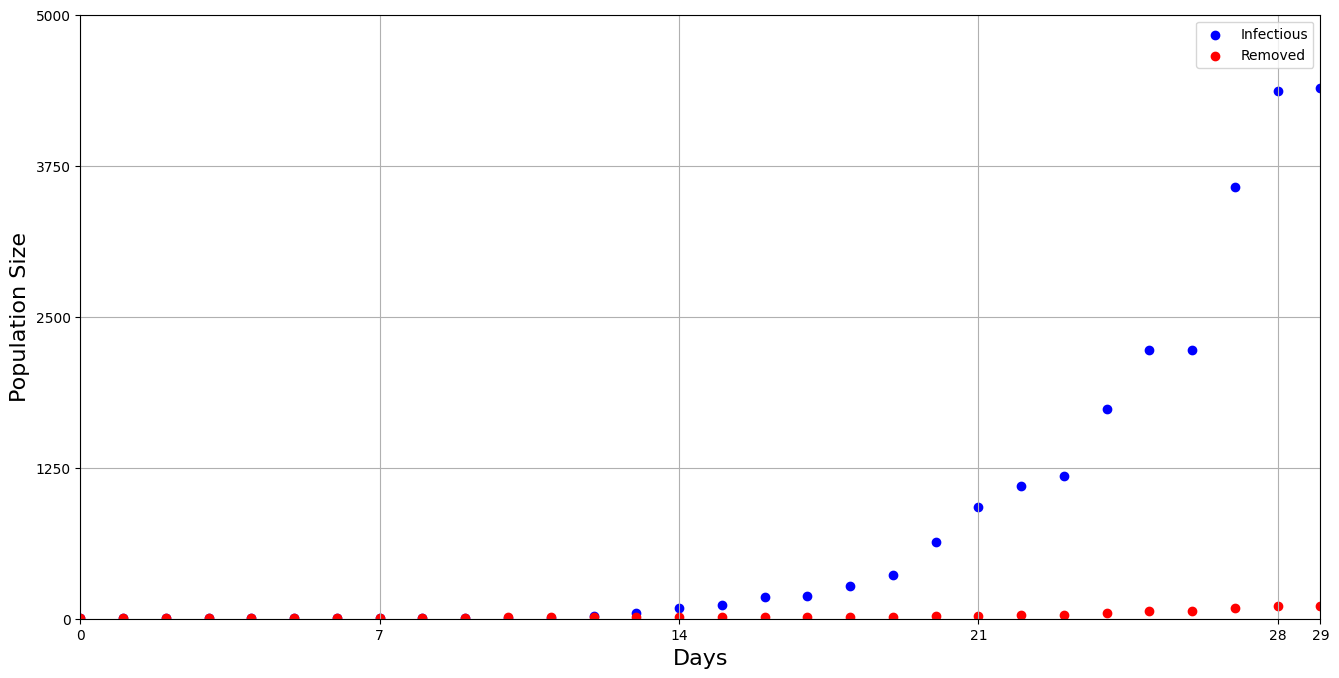

In [29]:
ir_plot(true_model)

# Fitting - Standard SIR Model (L2)

In [ ]:
theorised_model=Models.SIRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(65273511,0),stats.uniform(7,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(65273511,1),stats.uniform(7,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [43]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":500000,"sample_size":500,"distance_measure":ABC.l2_norm}
group_dim = lambda ys,i,norm=1: [norm*y[i] for y in ys]
summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2)]

fitted_model_rej,accepted_params_rej=ABC.abc_rejcection(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,sampling_details=sampling_details,summary_stats=summary_stats,show_plots=False)
print("Fitted Model - {}\n".format(fitted_model_rej))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_rej)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_rej.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_rej],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_rej],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Fitted Model - Population Size=65,273,511.0      
Initially Infected=7.0
Beta=0.267
Gamma=0.013
R_0=20.340

R0 - [15.937,25.627]
RSSE: 1,267.696
Beta - [0.261,0.271]
Gamma - [0.010,0.017]
Wall time: 5min 41s


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


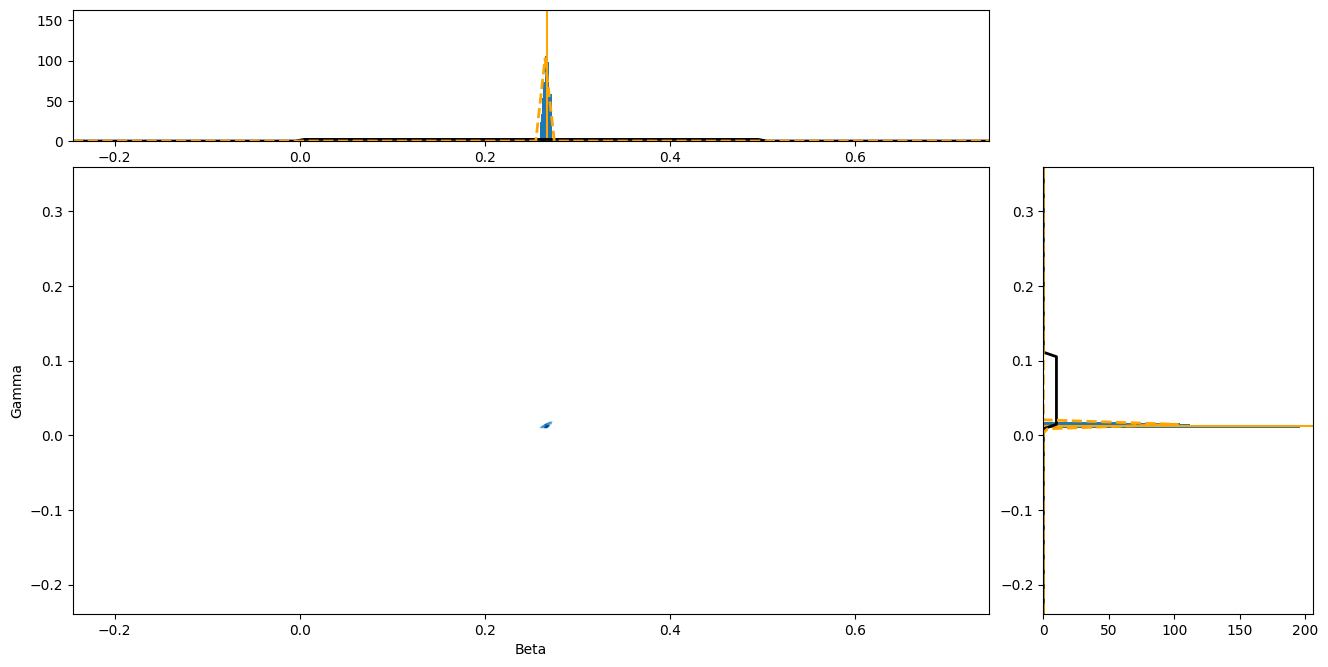

In [44]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_rej],predicted_vals=fitted_model_rej.params[2:],priors=sir_priors[2:],weights=None)

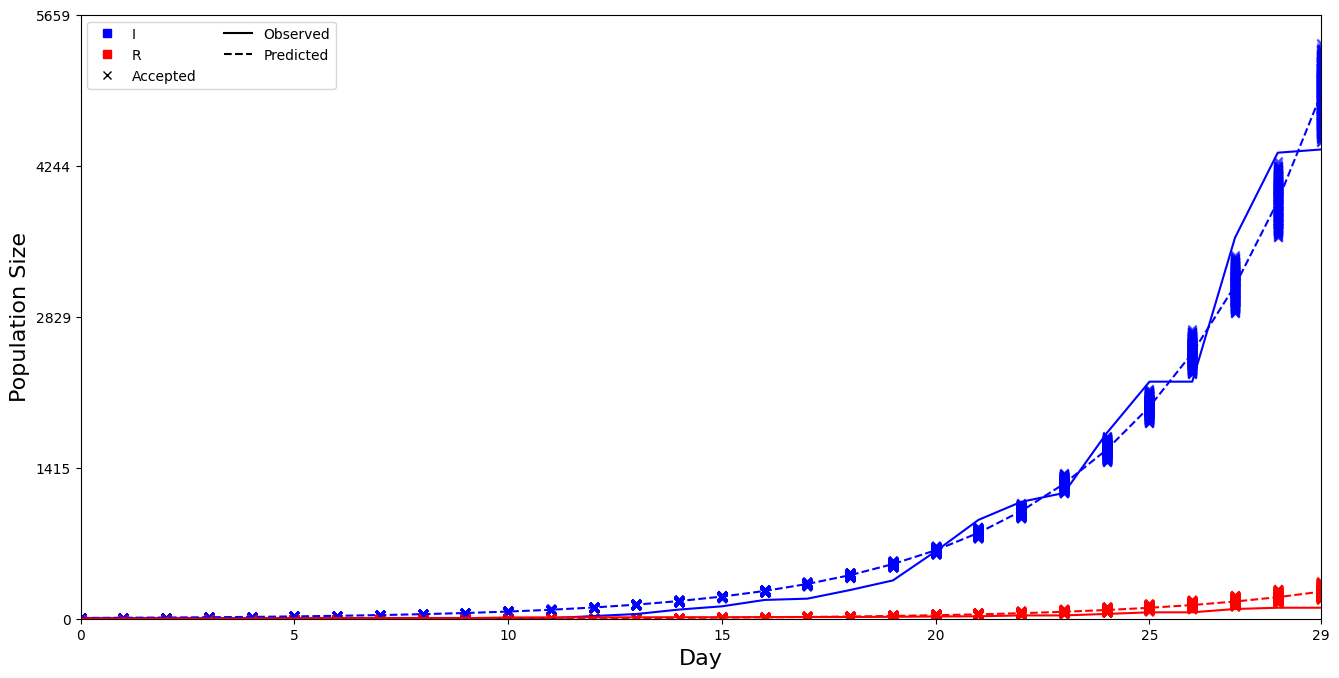

In [45]:
fig=plt.Figure()
ax=fig.add_subplot(1,1,1)

ax=plot_accepted_ir_observations(ax,x_obs=theorised_model.x_obs,y_obs=true_model.observe(),accepted_params=accepted_params_rej,predicted_model=fitted_model_rej)

fig

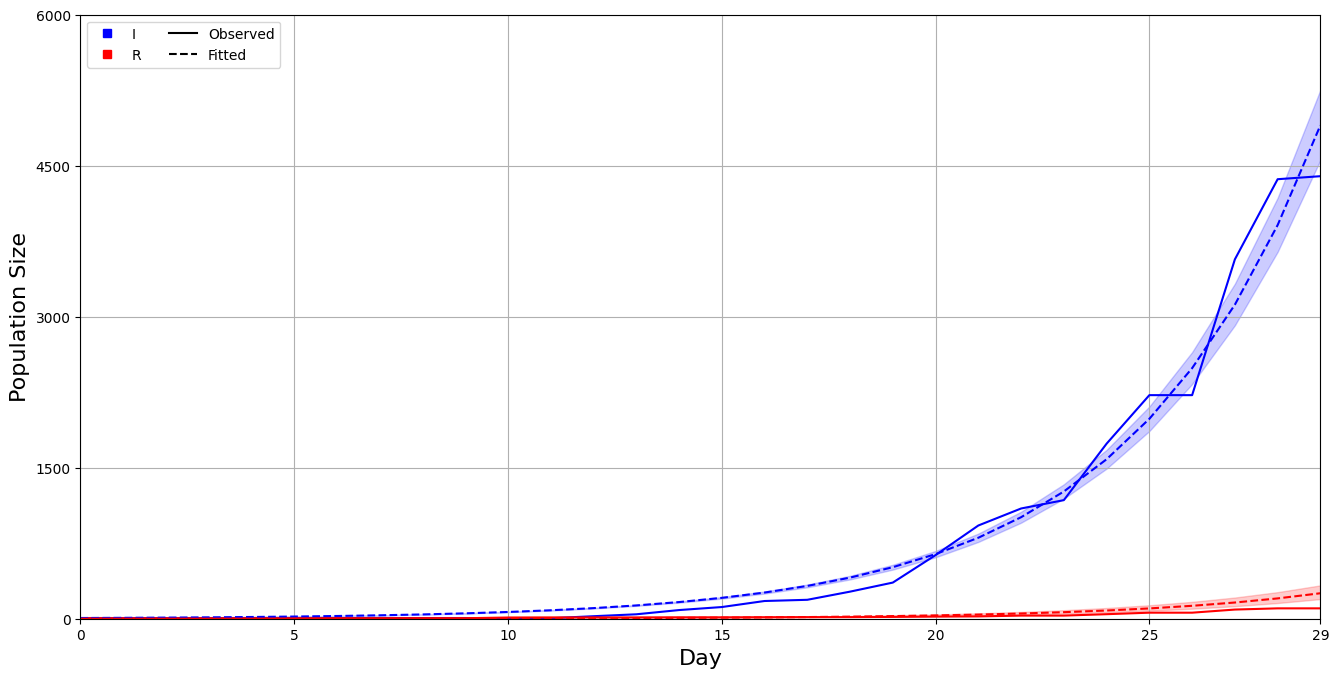

In [46]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_rej,accepted_params_rej,weights=None,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Fit - Adaptive SMC

In [40]:
%%time
# Adaptive ABC-SMC
np.random.seed(16111998) # Fix random seed

group_dim = lambda ys,i,norm=1: [norm*y[i] for y in ys]
f=lambda ys,i,norm=1:list(np.cumsum([norm*y[i] for y in ys]))
# summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2)]
summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2)]

fitted_model_adapt_smc,accepted_params_adapt_smc,weights_adapt_smc=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=2500,summary_stats=summary_stats,initial_scaling_factor=30000,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_model_adapt_smc))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_params_adapt_smc,weights=weights_adapt_smc)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_semi_model_ir.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_semi_params_ir],alpha=.05,weights=weights_adapt_smc)
gamma_ci=ci_parameters([p[3] for p in accepted_semi_params_ir],alpha=.05,weights=weights_adapt_smc)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

(131) - 100/100
Total Sims = 131 < 2,500

Perturbance Variances=[0.07646944 0.02117249 0.01023544 0.00085218]                       
(0/100 - 111) - 99/100 (eps=8,434.020>0.000)
Total Sims = 242 < 2,500

Perturbance Variances=[0.08173451 0.01886129 0.00660105 0.00081819]                       
(1/100 - 109) - 99/100 (eps=8,388.833>0.000)
Total Sims = 351 < 2,500

Perturbance Variances=[0.07974154 0.01557314 0.00437541 0.00074441]                       
(2/100 - 109) - 99/100 (eps=8,285.442>0.000)
Total Sims = 460 < 2,500

Perturbance Variances=[0.08604412 0.01693286 0.0031463  0.0008657 ]                       
(3/100 - 112) - 99/100 (eps=8,220.204>0.000)
Total Sims = 572 < 2,500

Perturbance Variances=[0.08084517 0.01657245 0.00232705 0.00075656]                       
(4/100 - 109) - 99/100 (eps=8,129.189>0.000)
Total Sims = 681 < 2,500

Perturbance Variances=[0.07807612 0.01291172 0.00266781 0.00064914]                       
(5/100 - 114) - 99/100 (eps=7,879.206>0.000)
Total Sims =

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


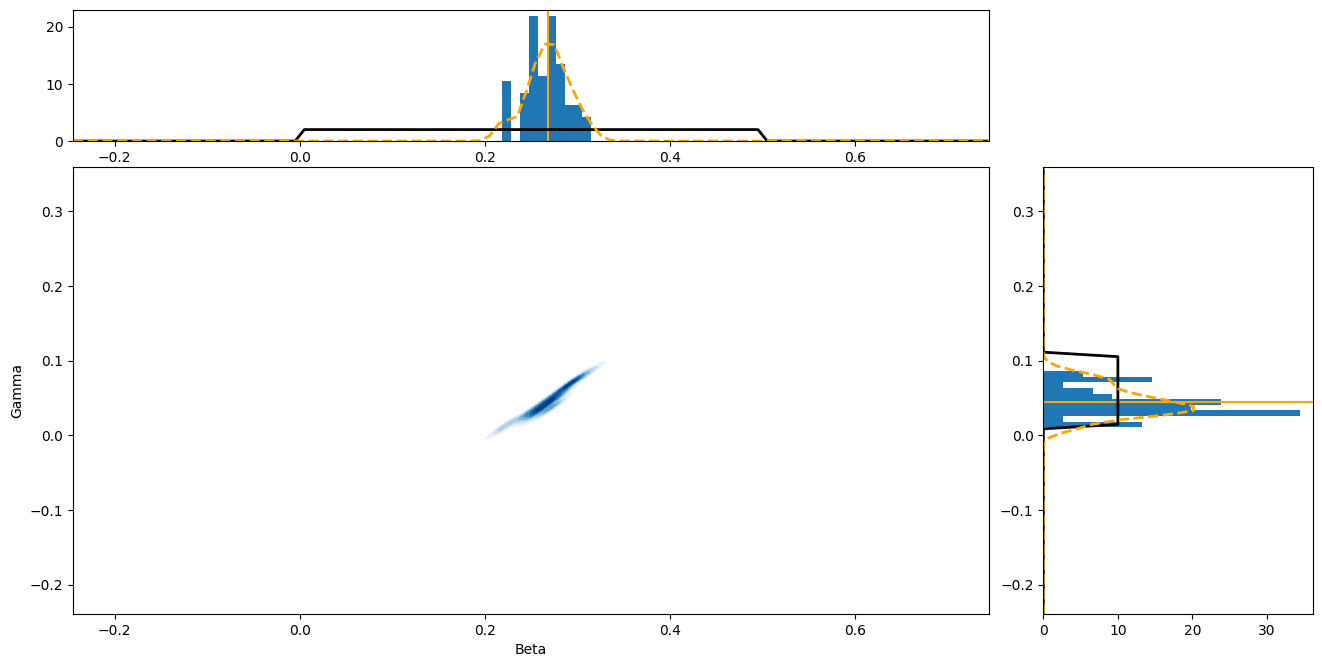

In [41]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_adapt_smc],predicted_vals=fitted_model_adapt_smc.params[2:],priors=sir_priors[2:],weights=weights_adapt_smc)

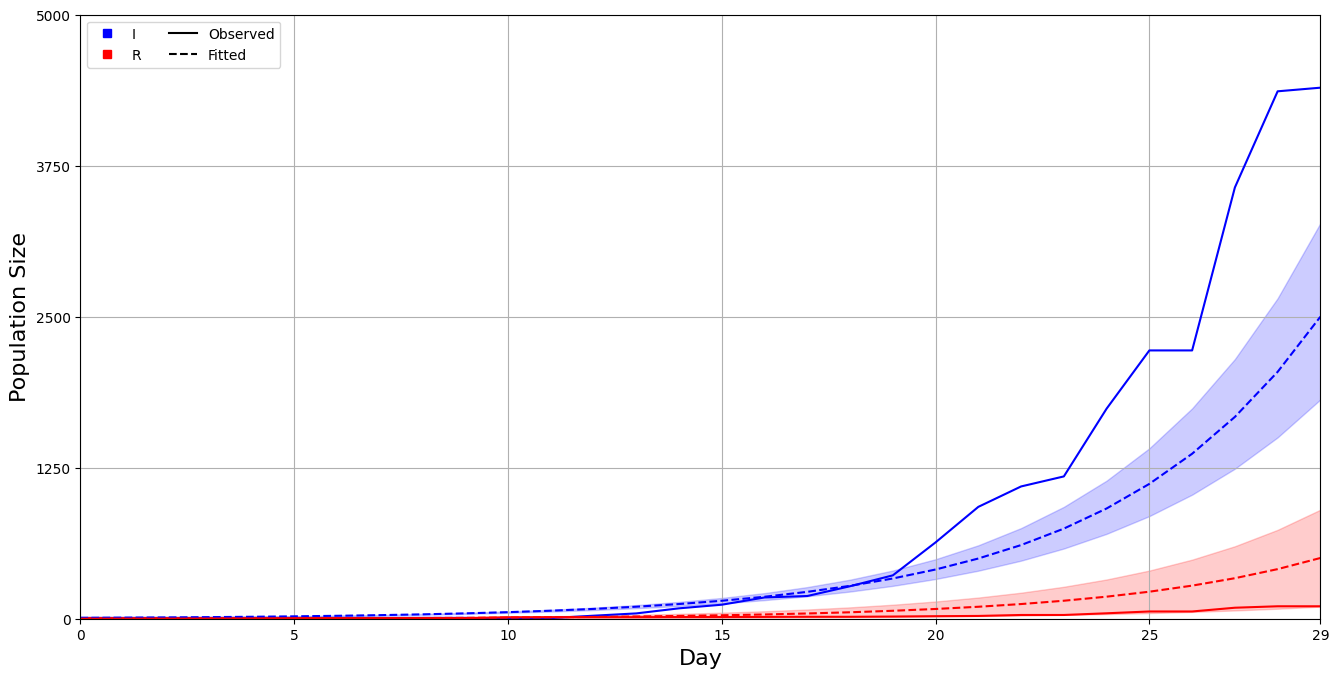

In [42]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_adapt_smc,accepted_params_adapt_smc,weights=weights_adapt_smc,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Fit Semi-Auto Adapative ABC-SMC (IR Model & 5,000 & L2_norm)

In [21]:
true_model=TrunFranceRonaData_IR()

In [22]:
theorised_model=Models.IRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(65273511,0),stats.uniform(7,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(65273511,1),stats.uniform(7,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [23]:
%%time
# ABC-SMC
np.random.seed(16111998) # Fix random seed

summary_stats,_=ABC.abc_semi_auto(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,
                                  priors=sir_smc_priors,distance_measure=ABC.l2_norm,n_pilot_samples=500000,n_pilot_acc=50,n_params_sample_size=5000,printing=True)
print(summary_stats[0](true_model.observe()))

fitted_semi_model_ir,accepted_semi_params_ir,weights_semi_ir=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=5000,summary_stats=summary_stats,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_semi_model_ir))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_semi_params_ir,weights=weights_semi_ir)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_semi_model_ir.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_semi_params_ir],alpha=.05,weights=weights_semi_ir)
gamma_ci=ci_parameters([p[3] for p in accepted_semi_params_ir],alpha=.05,weights=weights_semi_ir)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Calculated posteriors from pilot.                
Generated 5000 parameter sets.
Generated summary statistics
[403586376833133.4, 1099142447408874.5, -2139597156082.2778, -4401599963225.551]
(100) - 100/100
Total Sims = 100 < 5,000

Perturbance Variances=[0.08433743 0.02094379 0.02025981 0.00092927]                       
(0/100 - 112) - 99/100 (eps=19,769,761,958,359,972.000>0.000)
Total Sims = 212 < 5,000

Perturbance Variances=[0.07922412 0.0223264  0.01801515 0.000868  ]                       
(1/100 - 110) - 99/100 (eps=3,932,609,794,518,648.000>0.000)
Total Sims = 322 < 5,000

Perturbance Variances=[0.0851675  0.02395774 0.01833541 0.00085102]                       
(2/100 - 111) - 99/100 (eps=3,105,939,222,394,722.000>0.000)
Total Sims = 433 < 5,000

Perturbance Variances=[0.0897589  0.02722352 0.01601037 0.00082306]                       
(3/100 - 117) - 99/100 (eps=1,798,093,053,961,044.750>0.000)
Total Sims = 550 < 5,000

Perturbance Variances=[0.09015519 0.03034514 0.0137456

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


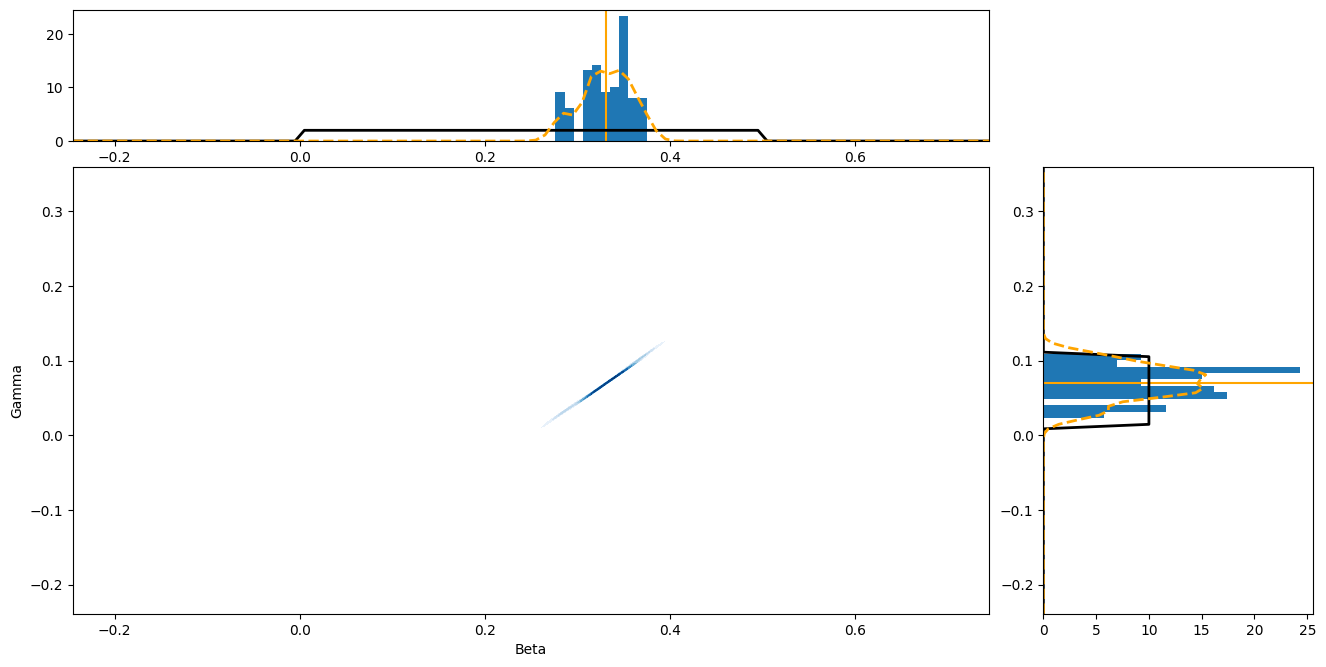

In [24]:
fig=plot_parameter_posteriors(
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_semi_params_ir],
    predicted_vals=fitted_semi_model_ir.params[2:],
    priors=sir_priors[2:],
    weights=weights_semi_ir)

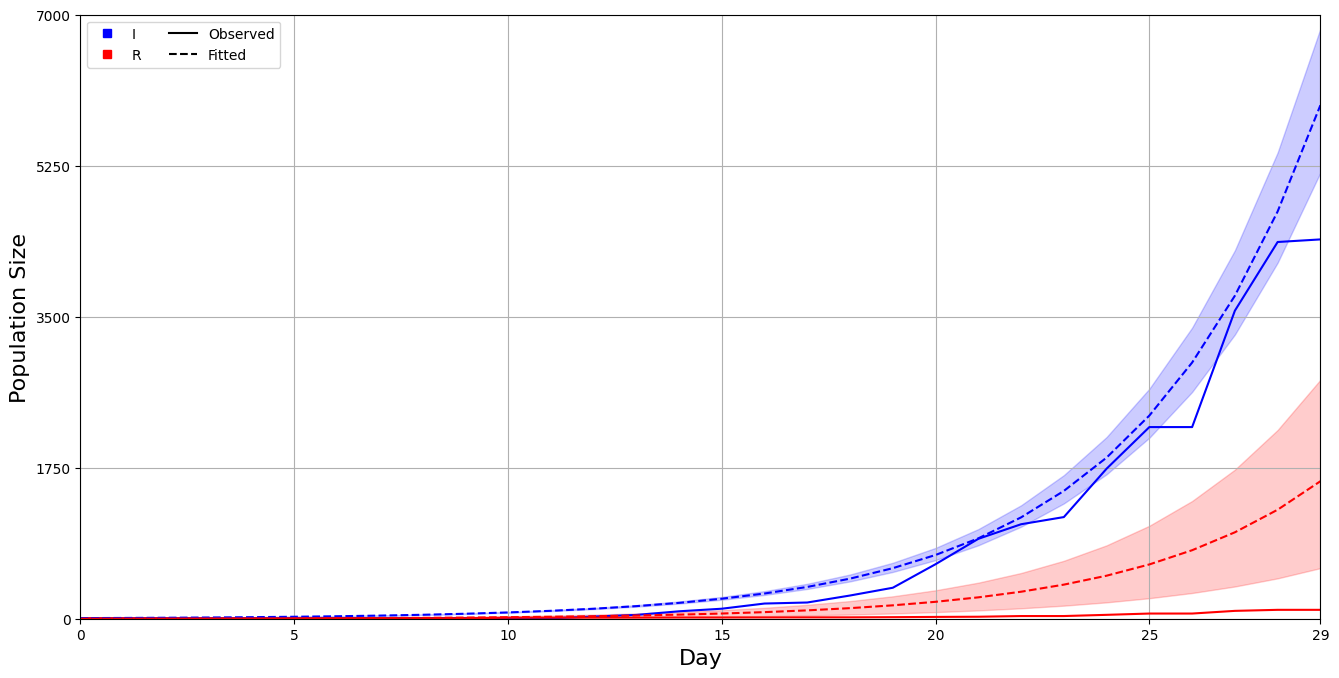

In [25]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

# temp_sir_fitted=Models.SIRModel(fitted_semi_model_ir.params[:2]+[0.18,0.04],30,x_obs=[[i] for i in range(30)])
temp_sir_fitted=Models.SIRModel(fitted_semi_model_ir.params,30,x_obs=[[i] for i in range(30)])

plot_ir_model_ci(ax,temp_sir_fitted.x_obs,TrunFranceRonaData().observe(),temp_sir_fitted,accepted_semi_params_ir,weights=weights_semi_ir,alpha=0.05)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Minimum Entropy

In [47]:
true_model=TrunFranceRonaData()

In [48]:
theorised_model=Models.SIRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(65273511,0),stats.uniform(7,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(65273511,1),stats.uniform(7,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [49]:
# # SUMMARY STATISTICS
# scaled to be similiar to peak_infections_date
final_infectious_ss=(lambda ys:[np.log(ys[-1][1])])
final_removed_ss=(lambda ys:[np.log(ys[-1][2])])

net_weekly_infections_ss=(lambda ys:[np.log(abs(ys[i][1]-ys[i-7][1])) for i in range(7,len(ys)-1,7)]) # weekly change in infections (dim=3)
net_weekly_removed_ss=(lambda ys:[np.log(abs(ys[i][2]-ys[i-7][2])) for i in range(7,len(ys)-1,7)])

net_daily_infections_ss=(lambda ys:[np.log(max(abs(ys[i+1][1]-ys[i][1]),1)) for i in range(0,len(ys)-1)]) # daily change in infections (dim=29)
net_daily_removed_ss=(lambda ys:[np.log(max(abs(ys[i+1][2]-ys[i][2]),np.e)) for i in range(0,len(ys)-1)])

mean_infectious_ss=(lambda ys:[5*np.log(np.mean([y[1] for y in ys]))])
mean_removed_ss=(lambda ys:[9*np.log(np.mean([y[2] for y in ys]))])

cum_sum_infectious_ss=(lambda ys:np.cumsum([y[1] for y in ys]))
cum_sum_removed_ss=(lambda ys:np.cumsum([y[1] for y in ys]))

summary_stats=[final_infectious_ss,final_removed_ss, #0,1
               net_weekly_infections_ss,net_weekly_removed_ss, #2,3
               net_daily_infections_ss,net_daily_removed_ss, #4,5
               mean_infectious_ss,mean_removed_ss, #6,7
               cum_sum_infectious_ss,cum_sum_removed_ss] #8,9

In [66]:
%%time
returned_stats=[(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5),(1,6,7)]
n_tests=10

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\n")
    best_stats,_=ABC.minimum_entropy(summary_stats,n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,n_samples=10000,n_accept=100,
                                     min_subset_size=2,max_subset_size=3,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats,10)

0/10 [(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5), (1, 6, 7)]
1/10 [(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5), (1, 6, 7), (4, 5)]
2/10 [(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5), (1, 6, 7), (4, 5), (1, 4, 5)]
3/10 [(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5), (1, 6, 7), (4, 5), (1, 4, 5), (1, 6)]
4/10 [(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5), (1, 6, 7), (4, 5), (1, 4, 5), (1, 6), (0, 4, 5)]
5/10 [(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5), (1, 6, 7), (4, 5), (1, 4, 5), (1, 6), (0, 4, 5), (1, 4, 6)]
6/10 [(1, 3, 4), (6, 7), (1, 5, 6), (0, 5), (1, 4), (0, 4, 5), (4, 5), (0, 1, 6), (4, 5), (1, 6, 7), (0, 1, 5), (1, 6, 7)

In [53]:
best_me_ss=[1,6,7]
me_ss=[summary_stats[i] for i in best_me_ss]

In [54]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":500000,"sample_size":500,"distance_measure":ABC.l2_norm}

fitted_model_me,accepted_params_me=ABC.abc_rejcection(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,sampling_details=sampling_details,summary_stats=me_ss,show_plots=False)
print("Fitted Model - {}\n".format(fitted_model_me))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_me)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_me.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_me],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_me],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Fitted Model - Population Size=65,273,511.0      
Initially Infected=7.0
Beta=0.250
Gamma=0.011
R_0=22.468

R0 - [19.122,25.334]
RSSE: 1,334.740
Beta - [0.238,0.263]
Gamma - [0.010,0.013]
Wall time: 5min 20s


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


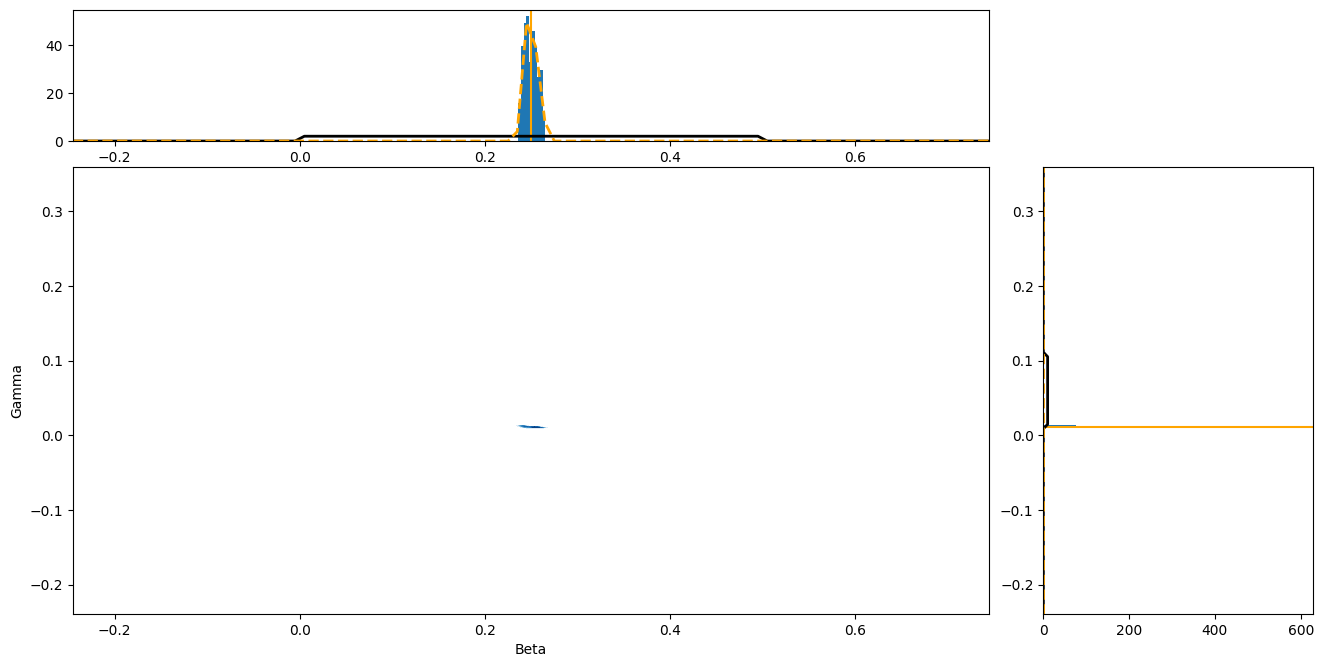

In [55]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_me],predicted_vals=fitted_model_me.params[2:],priors=sir_priors[2:],weights=None)

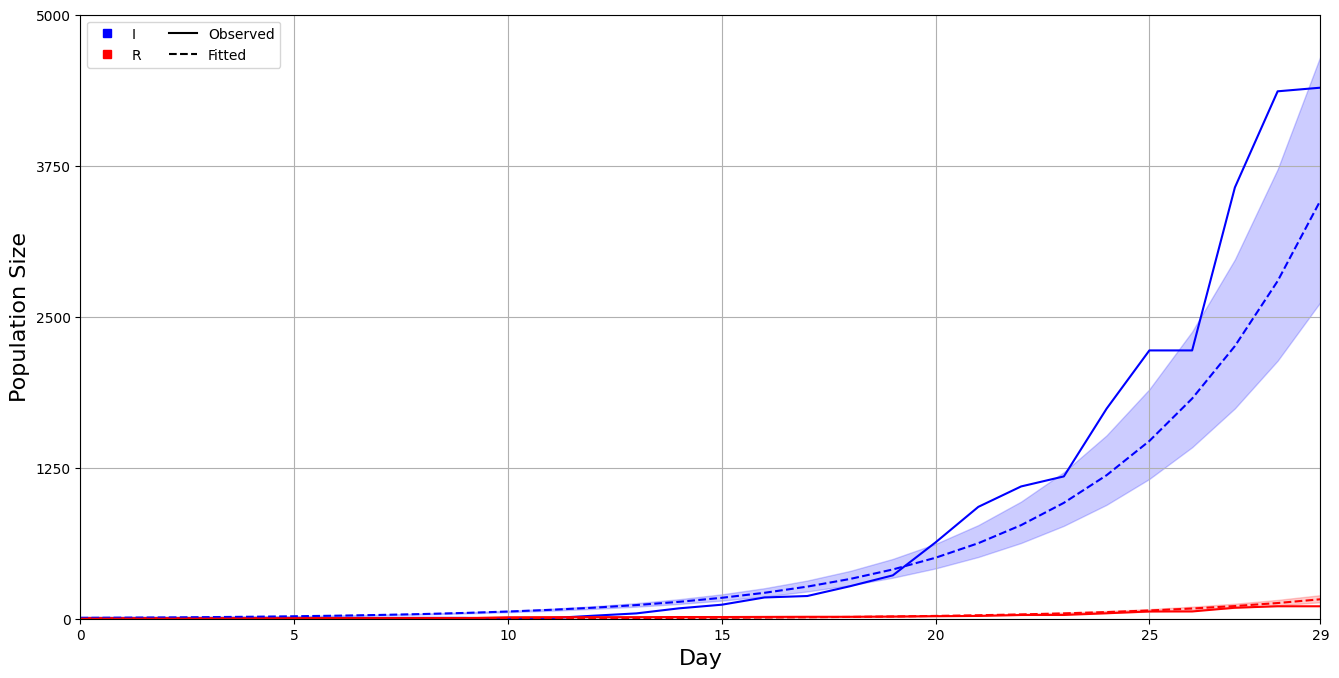

In [56]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_me,accepted_params_me,weights=None,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

In [59]:
%%time
# Adaptive ABC-SMC
np.random.seed(16111998) # Fix random seed

fitted_model_adapt_me,accepted_params_adapt_me,weights_adapt_me=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=2500,summary_stats=me_ss,initial_scaling_factor=25,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_model_adapt_me))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_params_adapt_me,weights=weights_adapt_me)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_adapt_me.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_adapt_me],alpha=.05,weights=weights_adapt_me)
gamma_ci=ci_parameters([p[3] for p in accepted_params_adapt_me],alpha=.05,weights=weights_adapt_me)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

(235) - 100/100
Total Sims = 235 < 2,500

Perturbance Variances=[0.08518295 0.01946798 0.00318787 0.00086749]                       
(0/100 - 107) - 99/100 (eps=23.015>0.000)
Total Sims = 342 < 2,500

Perturbance Variances=[0.07618366 0.01537504 0.00272561 0.00074464]                       
(1/100 - 112) - 99/100 (eps=21.677>0.000)
Total Sims = 454 < 2,500

Perturbance Variances=[0.08301808 0.0142618  0.0021801  0.00089139]                       
(2/100 - 114) - 99/100 (eps=20.720>0.000)
Total Sims = 568 < 2,500

Perturbance Variances=[0.07242632 0.01292113 0.00165596 0.00091062]                       
(3/100 - 114) - 99/100 (eps=20.224>0.000)
Total Sims = 682 < 2,500

Perturbance Variances=[0.06877875 0.01541937 0.00160928 0.00067729]                       
(4/100 - 108) - 99/100 (eps=19.799>0.000)
Total Sims = 790 < 2,500

Perturbance Variances=[0.06410762 0.01843873 0.00172403 0.00061854]                       
(5/100 - 114) - 99/100 (eps=19.526>0.000)
Total Sims = 904 < 2,500

Pert

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


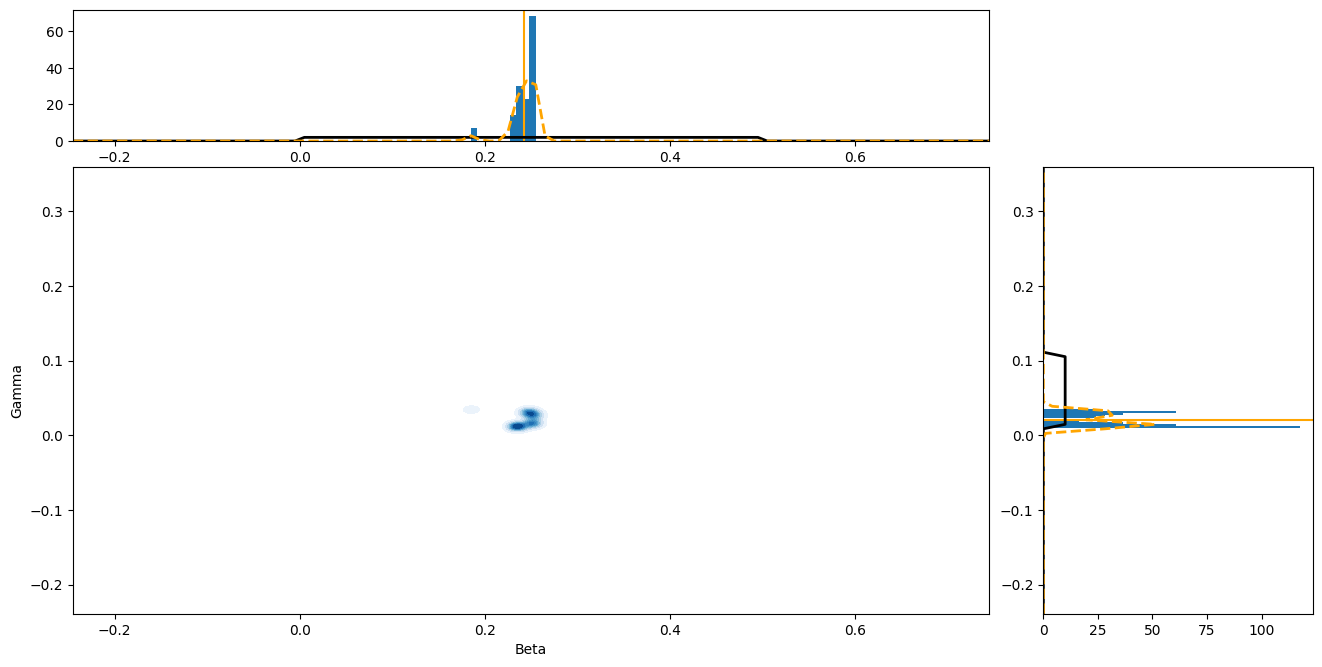

In [60]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_adapt_me],predicted_vals=fitted_model_adapt_me.params[2:],priors=sir_priors[2:],weights=weights_adapt_me)

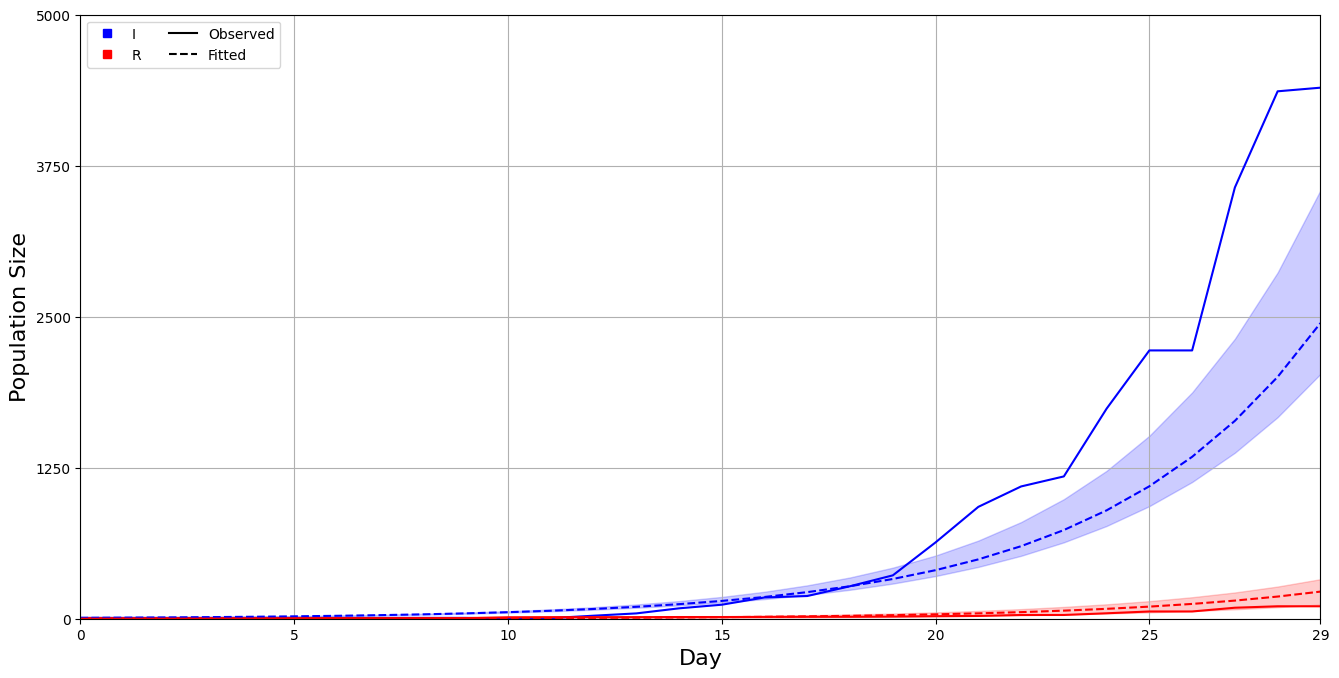

In [61]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_adapt_me,accepted_params_adapt_me,weights=weights_adapt_me,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Two-Step ME

In [62]:
true_model=TrunFranceRonaData()

In [63]:
theorised_model=Models.SIRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(65273511,0),stats.uniform(7,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(65273511,1),stats.uniform(7,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [64]:
# # SUMMARY STATISTICS
# scaled to be similiar to peak_infections_date
final_infectious_ss=(lambda ys:[np.log(ys[-1][1])])
final_removed_ss=(lambda ys:[np.log(ys[-1][2])])

net_weekly_infections_ss=(lambda ys:[np.log(abs(ys[i][1]-ys[i-7][1])) for i in range(7,len(ys)-1,7)]) # weekly change in infections (dim=3)
net_weekly_removed_ss=(lambda ys:[np.log(abs(ys[i][2]-ys[i-7][2])) for i in range(7,len(ys)-1,7)])

net_daily_infections_ss=(lambda ys:[np.log(max(abs(ys[i+1][1]-ys[i][1]),1)) for i in range(0,len(ys)-1)]) # daily change in infections (dim=29)
net_daily_removed_ss=(lambda ys:[np.log(max(abs(ys[i+1][2]-ys[i][2]),np.e)) for i in range(0,len(ys)-1)])

mean_infectious_ss=(lambda ys:[5*np.log(np.mean([y[1] for y in ys]))])
mean_removed_ss=(lambda ys:[9*np.log(np.mean([y[2] for y in ys]))])

cum_sum_infectious_ss=(lambda ys:np.cumsum([y[1] for y in ys]))
cum_sum_removed_ss=(lambda ys:np.cumsum([y[1] for y in ys]))

summary_stats=[final_infectious_ss,final_removed_ss, #0,1
               net_weekly_infections_ss,net_weekly_removed_ss, #2,3
               net_daily_infections_ss,net_daily_removed_ss, #4,5
               mean_infectious_ss,mean_removed_ss, #6,7
               cum_sum_infectious_ss,cum_sum_removed_ss] #8,9

In [65]:
%%time
returned_stats_me_2=[]
n_tests=20

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats_me_2,end="\n")
    
    best_stats,_=ABC.two_step_minimum_entropy(summary_stats=summary_stats,n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,
                                              priors=sir_priors,min_subset_size=2,max_subset_size=3,n_samples=10000,n_accept=100,n_keep=100,printing=False)
    returned_stats_me_2.append(best_stats)
    
print("\n\nResults")
print_results(returned_stats_me_2,len(summary_stats))

0/20 []
1/20 [(2, 3, 6)]  
2/20 [(2, 3, 6), (0, 3, 8)]
3/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3)]
4/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6)]
5/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9)]
6/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9), (1, 2, 6)]
7/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9), (1, 2, 6), (1, 5, 8)]
8/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9), (1, 2, 6), (1, 5, 8), (1, 2, 5)]
9/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9), (1, 2, 6), (1, 5, 8), (1, 2, 5), (0, 7, 9)]
10/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9), (1, 2, 6), (1, 5, 8), (1, 2, 5), (0, 7, 9), (1, 5, 8)]
11/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9), (1, 2, 6), (1, 5, 8), (1, 2, 5), (0, 7, 9), (1, 5, 8), (0, 2, 3)]
12/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7, 9), (1, 2, 6), (1, 5, 8), (1, 2, 5), (0, 7, 9), (1, 5, 8), (0, 2, 3), (0, 5, 7)]
13/20 [(2, 3, 6), (0, 3, 8), (0, 2, 3), (2, 3, 6), (2, 7,

In [73]:
best_me2_ss=[1,5,8]
me2_ss=[summary_stats[i] for i in best_me2_ss]

In [74]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":500000,"sample_size":500,"distance_measure":ABC.l2_norm}

fitted_model_me2,accepted_params_me2=ABC.abc_rejcection(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,sampling_details=sampling_details,summary_stats=me2_ss,show_plots=False)
print("Fitted Model - {}\n".format(fitted_model_me2))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_me2)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_me2.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_me2],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_me2],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Fitted Model - Population Size=65,273,511.0      
Initially Infected=7.0
Beta=0.306
Gamma=0.054
R_0=5.628

R0 - [3.391,19.094]


NameError: name 'fitted_model_mee' is not defined

In [80]:
# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_me2)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_me2.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_me2],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_me2],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

R0 - [3.382,20.541]
RSSE: 1,502.248
Beta - [0.263,0.359]
Gamma - [0.011,0.108]


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


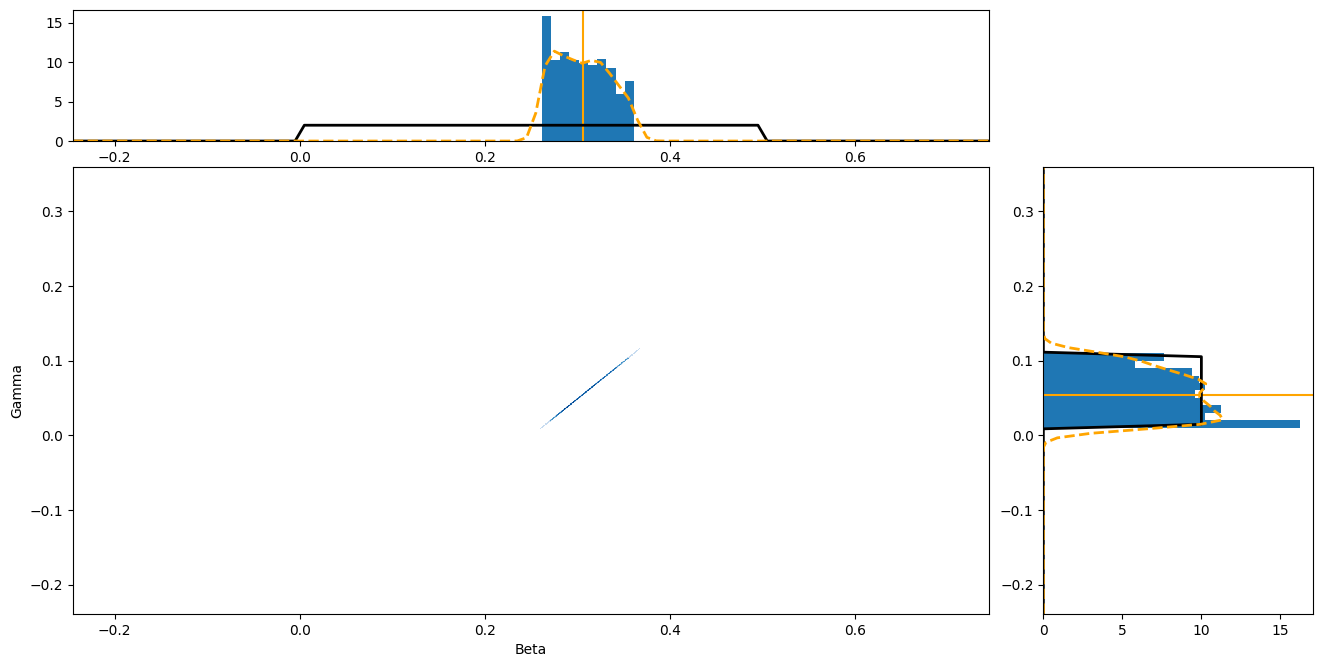

In [75]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_me2],predicted_vals=fitted_model_me2.params[2:],priors=sir_priors[2:],weights=None)

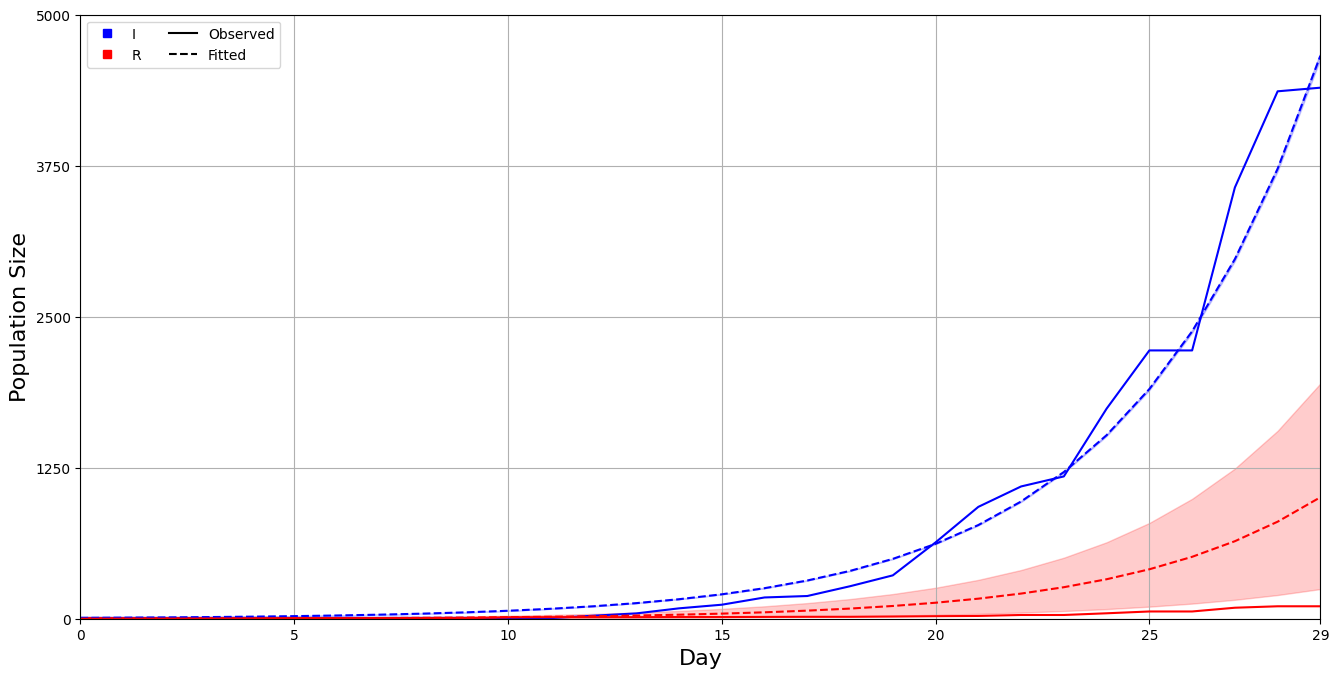

In [76]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_me2,accepted_params_me2,weights=None,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

In [77]:
%%time
# Adaptive ABC-SMC
np.random.seed(16111998) # Fix random seed

fitted_model_adapt_me2,accepted_params_adapt_me2,weights_adapt_me2=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=5000,summary_stats=me2_ss,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_model_adapt_me2))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_params_adapt_me2,weights=weights_adapt_me2)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_adapt_me2.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_adapt_me2],alpha=.05,weights=weights_adapt_me2)
gamma_ci=ci_parameters([p[3] for p in accepted_params_adapt_me2],alpha=.05,weights=weights_adapt_me2)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

(100) - 100/100
Total Sims = 100 < 5,000

Perturbance Variances=[0.06984171 0.02053917 0.01797321 0.00090909]                       
(0/100 - 115) - 99/100 (eps=351,270.102>0.000)
Total Sims = 215 < 5,000

Perturbance Variances=[0.06475007 0.02044626 0.01166451 0.00085465]                       
(1/100 - 105) - 99/100 (eps=71,229.201>0.000)
Total Sims = 320 < 5,000

Perturbance Variances=[0.06925221 0.01982143 0.00672444 0.00080142]                       
(2/100 - 114) - 99/100 (eps=37,702.462>0.000)
Total Sims = 434 < 5,000

Perturbance Variances=[0.07874597 0.01634544 0.00545619 0.00072078]                       
(3/100 - 104) - 99/100 (eps=37,291.239>0.000)
Total Sims = 538 < 5,000

Perturbance Variances=[0.06764247 0.01625726 0.00483799 0.00074308]                       
(4/100 - 108) - 99/100 (eps=37,213.538>0.000)
Total Sims = 646 < 5,000

Perturbance Variances=[0.05201924 0.01584311 0.00500889 0.00085449]                       
(5/100 - 112) - 99/100 (eps=37,127.933>0.000)
Total

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


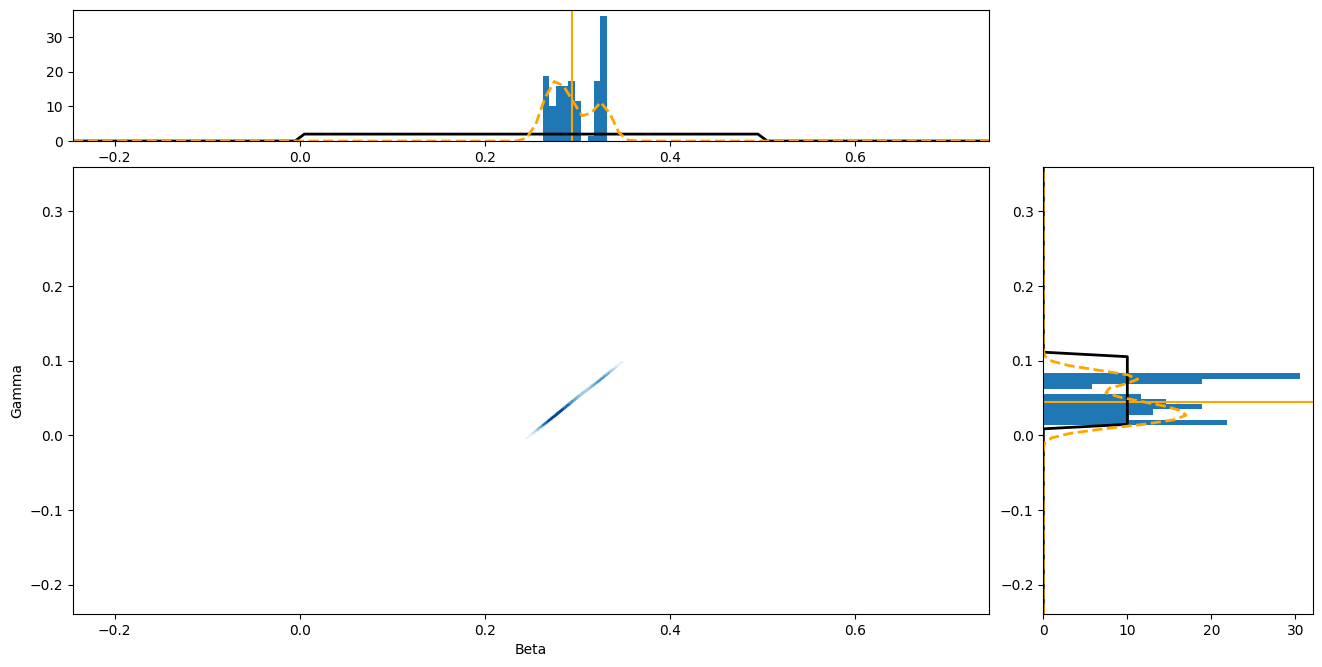

In [78]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_adapt_me2],predicted_vals=fitted_model_adapt_me2.params[2:],priors=sir_priors[2:],weights=weights_adapt_me2)

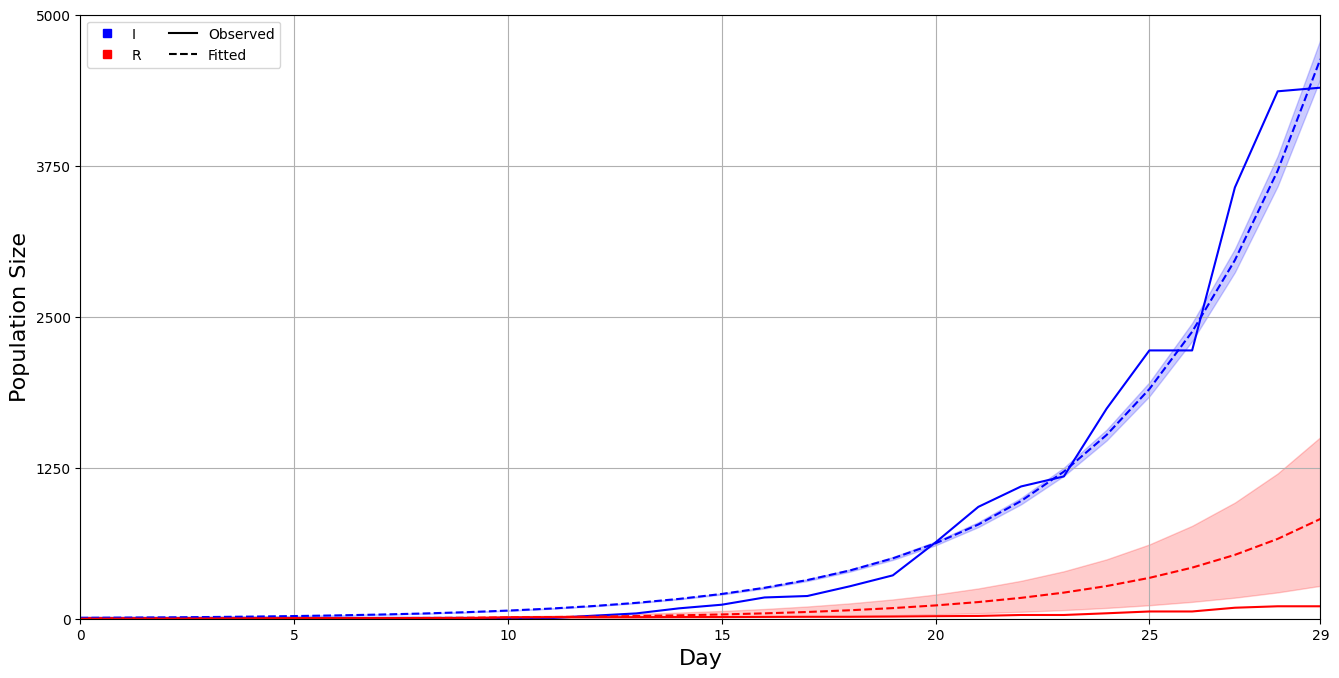

In [79]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_adapt_me2,accepted_params_adapt_me2,weights=weights_adapt_me2,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

In [103]:
for i in [0.014,0.082]:
    print("{:.1f}".format(1/i))

71.4
12.2
